In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 5

# necessary modules -------------------------------------------------------------------------------------
import sys
import os
sys.path.append('/home/ollie/loziel/pyfesom2/')
sys.path.append('/home/ollie/loziel/pyfesom2/SkillMetrics')
sys.path.append('/home/ollie/loziel/pyfesom2/codes/py_f2recom_develop/GlobalAssessment/')
import skill_metrics as sm
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.colors as colors
import time
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from load_interp_GLODAP_python3 import GLODAPdata

Autosaving every 5 seconds


In [2]:
runid      =  'fesom'
resultpath = '/work/ollie/ogurses/output_f2r2/spinup_1800_1850/A/'
meshpath = '/work/ollie/loziel/mesh/core2_meanz/'
# period of analysis 
first_year = 1997
last_year  = 2007
depth_limit = 50
mapproj = 'rob'
ncfileAlk                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TAlk.nc'
ncfileDIC                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TCO2.nc'

mesh       = pf.load_mesh(meshpath)
meshdiag = pf.get_meshdiag(mesh)
years = np.arange(first_year, last_year+1,1)
labelfesom = 'FESOM {0}-{1}'.format(last_year-10,last_year)
labelwoa = 'GLODAP'
unit_dic = 'DIC [mmol m$^{-3}$]' # equals to mumol/L
unit_alk = 'Alk [mmol m$^{-3}$]' # equals to mumol/L

/work/ollie/loziel/mesh/core2_meanz/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/loziel/mesh/core2_meanz/pickle_mesh_py3_fesom2


In [3]:
factor = 1
# load data -------------------------------------------------------------------------------------
DICfesom = pf.get_data(resultpath, "DIC", years, mesh,
                       how="mean", compute=True, runid=runid, silent=True)

Alkfesom = pf.get_data(resultpath, "Alk", years, mesh,
                       how="mean", compute=True, runid=runid, silent=True)

DICfesom = factor * DICfesom
Alkfesom = factor * Alkfesom

DICglo_input = GLODAPdata(runid,resultpath,meshpath,ncfileDIC,'TCO2', get_overview=False)
Alkglo_input = GLODAPdata(runid,resultpath,meshpath,ncfileAlk,'TAlk', get_overview=False)

DICglo = factor * DICglo_input.glodap_int
DICglo[DICfesom == 0] = 0

Alkglo = factor * Alkglo_input.glodap_int
Alkglo[Alkfesom == 0] = 0

 # get level depth index closest to depth_limit
i_depth_limit = pf.ind_for_depth(depth_limit, mesh)
            
# corresponding level depth
depth_limit_level = - mesh.zlev[i_depth_limit]
            
# corresponding layer depth (where concentrations are defined):
depth_limit_layer = - DICglo_input.layer_depths[i_depth_limit]
            
# print overview of chosen depth
print('DIN as mean over depth \nwith max layer depth = {0} \n(level depth = {1}m, mesh index {2})'.format(
                depth_limit_layer,depth_limit_level,i_depth_limit))
            
# mean over depth

DICfesom_mean = np.mean(DICfesom[:,:i_depth_limit], axis = 1)
DICglo_mean = np.mean(DICglo[:,:i_depth_limit], axis = 1)

Alkfesom_mean = np.mean(Alkfesom[:,:i_depth_limit], axis = 1)
Alkglo_mean = np.mean(Alkglo[:,:i_depth_limit], axis = 1)

***
Loading GLODAP file: /work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TCO2.nc
***
/work/ollie/loziel/mesh/core2_meanz/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/loziel/mesh/core2_meanz/pickle_mesh_py3_fesom2
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***
***
Loading GLODAP file: /work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TAlk.nc
***
/work/ollie/loziel/mesh/core2_meanz/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/loziel/mesh/core2_meanz/pickle_mesh_py3_fesom2
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***
DIN as mean over depth 
with max layer depth = 55.0 
(level depth = 50.0m, mesh index 6)


In [4]:
# Load and derive profiles

nod_area = np.ma.masked_equal(meshdiag.nod_area.values, 0)
mask = pf.get_mask(mesh, "Global Ocean")

DICfesom_by_area = ((np.ma.masked_equal(DICfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
DICglo_by_area = ((np.ma.masked_equal(DICglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

DICfesom_weighted_Global = DICfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
DICglo_weighted_Global = DICglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

Alkfesom_by_area = ((np.ma.masked_equal(Alkfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
Alkglo_by_area = ((np.ma.masked_equal(Alkglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

Alkfesom_weighted_Global = Alkfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
Alkglo_weighted_Global = Alkglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

mask = pf.get_mask(mesh, "Atlantic_Basin")

DICfesom_by_area = ((np.ma.masked_equal(DICfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
DICglo_by_area = ((np.ma.masked_equal(DICglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

DICfesom_weighted_Atlantic = DICfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
DICglo_weighted_Atlantic = DICglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

Alkfesom_by_area = ((np.ma.masked_equal(Alkfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
Alkglo_by_area = ((np.ma.masked_equal(Alkglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

Alkfesom_weighted_Atlantic = Alkfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
Alkglo_weighted_Atlantic = Alkglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

mask = pf.get_mask(mesh, "Pacific_Basin")

DICfesom_by_area = ((np.ma.masked_equal(DICfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
DICglo_by_area = ((np.ma.masked_equal(DICglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

DICfesom_weighted_Pacific = DICfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
DICglo_weighted_Pacific = DICglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

Alkfesom_by_area = ((np.ma.masked_equal(DICfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
Alkglo_by_area = ((np.ma.masked_equal(DICglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

Alkfesom_weighted_Pacific = Alkfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
Alkglo_weighted_Pacific = Alkglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

mask = pf.get_mask(mesh, "Indian_Basin")

DICfesom_by_area = ((np.ma.masked_equal(DICfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
DICglo_by_area = ((np.ma.masked_equal(DICglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

DICfesom_weighted_Indian = DICfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
DICglo_weighted_Indian = DICglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

Alkfesom_by_area = ((np.ma.masked_equal(Alkfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
Alkglo_by_area = ((np.ma.masked_equal(Alkglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

Alkfesom_weighted_Indian = Alkfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
Alkglo_weighted_Indian = Alkglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

mask = pf.get_mask(mesh, "Arctic_Basin")

DICfesom_by_area = ((np.ma.masked_equal(DICfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
DICglo_by_area = ((np.ma.masked_equal(DICglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

DICfesom_weighted_Arctic = DICfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
DICglo_weighted_Arctic = DICglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

Alkfesom_by_area = ((np.ma.masked_equal(Alkfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
Alkglo_by_area = ((np.ma.masked_equal(Alkglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

Alkfesom_weighted_Arctic = Alkfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
Alkglo_weighted_Arctic = Alkglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

mask = pf.get_mask(mesh, "Southern_Ocean_Basin")

DICfesom_by_area = ((np.ma.masked_equal(DICfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
DICglo_by_area = ((np.ma.masked_equal(DICglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

DICfesom_weighted_Southern = DICfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
DICglo_weighted_Southern = DICglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

Alkfesom_by_area = ((np.ma.masked_equal(Alkfesom[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))
Alkglo_by_area = ((np.ma.masked_equal(Alkglo[mask,:],0) * nod_area[:-1,:].T[mask]).mean(axis=0))

Alkfesom_weighted_Southern = Alkfesom_by_area/nod_area[:-1,:].T[mask].mean(axis=0)
Alkglo_weighted_Southern = Alkglo_by_area/nod_area[:-1,:].T[mask].mean(axis=0)

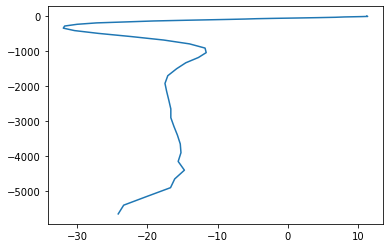

In [5]:
# Check
plt.plot(DICfesom_weighted_Global-DICglo_weighted_Global, mesh.zlev[:-1],label = 'Global Ocean')

In [6]:
# Interpolate maps
box=[-180, 180, -80, 90]
res=[360, 180]
radius_of_influence = 80000
levels_dic = np.arange(1900,2220,20) * factor
levels_dic_anom = np.arange(-200,220,20) * factor
levels_alk = np.arange(2100,2420,20) * factor
levels_alk_anom = np.arange(-200,220,20) * factor
left, right, down, up = box
lonNumber, latNumber = res

lonreg = np.linspace(left, right, lonNumber)
latreg = np.linspace(down, up, latNumber)
lonreg2, latreg2 = np.meshgrid(lonreg, latreg)

if not isinstance(DICfesom_mean, list):
    DICfesom_mean = [DICfesom_mean]
    Alkfesom_mean = [Alkfesom_mean]

DIC_interpolated = pf.interpolate_for_plot(DICfesom_mean,
                                       mesh,
                                       lonreg2,
                                       latreg2,
                                       interp="nn",
                                       distances_path=None,
                                       inds_path=None,
                                       radius_of_influence=radius_of_influence,
                                       basepath=None,
                                       qhull_path=None)

DIC_anom_interpolated = pf.interpolate_for_plot((DICfesom_mean-DICglo_mean),
                                       mesh,
                                       lonreg2,
                                       latreg2,
                                       interp="nn",
                                       distances_path=None,
                                       inds_path=None,
                                       radius_of_influence=radius_of_influence,
                                       basepath=None,
                                       qhull_path=None)

Alk_interpolated = pf.interpolate_for_plot(Alkfesom_mean,
                                       mesh,
                                       lonreg2,
                                       latreg2,
                                       interp="nn",
                                       distances_path=None,
                                       inds_path=None,
                                       radius_of_influence=radius_of_influence,
                                       basepath=None,
                                       qhull_path=None)

Alk_anom_interpolated = pf.interpolate_for_plot((Alkfesom_mean-Alkglo_mean),
                                       mesh,
                                       lonreg2,
                                       latreg2,
                                       interp="nn",
                                       distances_path=None,
                                       inds_path=None,
                                       radius_of_influence=radius_of_influence,
                                       basepath=None,
                                       qhull_path=None)


m2 = pf.mask_ne(lonreg2, latreg2)

for i in range(len(DIC_interpolated)):
    DIC_interpolated[i] = np.ma.masked_where(m2, DIC_interpolated[i])
    DIC_interpolated[i] = np.ma.masked_equal(DIC_interpolated[i], 0)
for i in range(len(DIC_anom_interpolated)):
    DIC_anom_interpolated[i] = np.ma.masked_where(m2, DIC_anom_interpolated[i])
    DIC_anom_interpolated[i] = np.ma.masked_equal(DIC_anom_interpolated[i], 0)
    
for i in range(len(Alk_interpolated)):
    Alk_interpolated[i] = np.ma.masked_where(m2, Alk_interpolated[i])
    Alk_interpolated[i] = np.ma.masked_equal(Alk_interpolated[i], 0)
for i in range(len(Alk_anom_interpolated)):
    Alk_anom_interpolated[i] = np.ma.masked_where(m2, Alk_anom_interpolated[i])
    Alk_anom_interpolated[i] = np.ma.masked_equal(Alk_anom_interpolated[i], 0)
    
elem_no_nan = pf.cut_region(mesh, box)
no_cyclic_elem2 = pf.get_no_cyclic(mesh, elem_no_nan)

data_levels_Alk = pf.get_plot_levels(levels_alk, Alk_interpolated, lev_to_data=False)
data_int_cyc_Alk, lon_cyc_Alk = pf.add_cyclic_point(Alk_interpolated[0], coord=lonreg)
data_levels_Alk_anom = pf.get_plot_levels(levels_alk_anom, Alk_anom_interpolated, lev_to_data=False)
data_int_cyc_Alk_anom, lon_cyc_Alk_anom = pf.add_cyclic_point(Alk_anom_interpolated[0], coord=lonreg)

data_levels_DIC = pf.get_plot_levels(levels_dic, DIC_interpolated, lev_to_data=False)
data_int_cyc_DIC, lon_cyc_DIC = pf.add_cyclic_point(DIC_interpolated[0], coord=lonreg)
data_levels_DIC_anom = pf.get_plot_levels(levels_dic_anom, DIC_anom_interpolated, lev_to_data=False)
data_int_cyc_DIC_anom, lon_cyc_DIC_anom = pf.add_cyclic_point(DIC_anom_interpolated[0], coord=lonreg)

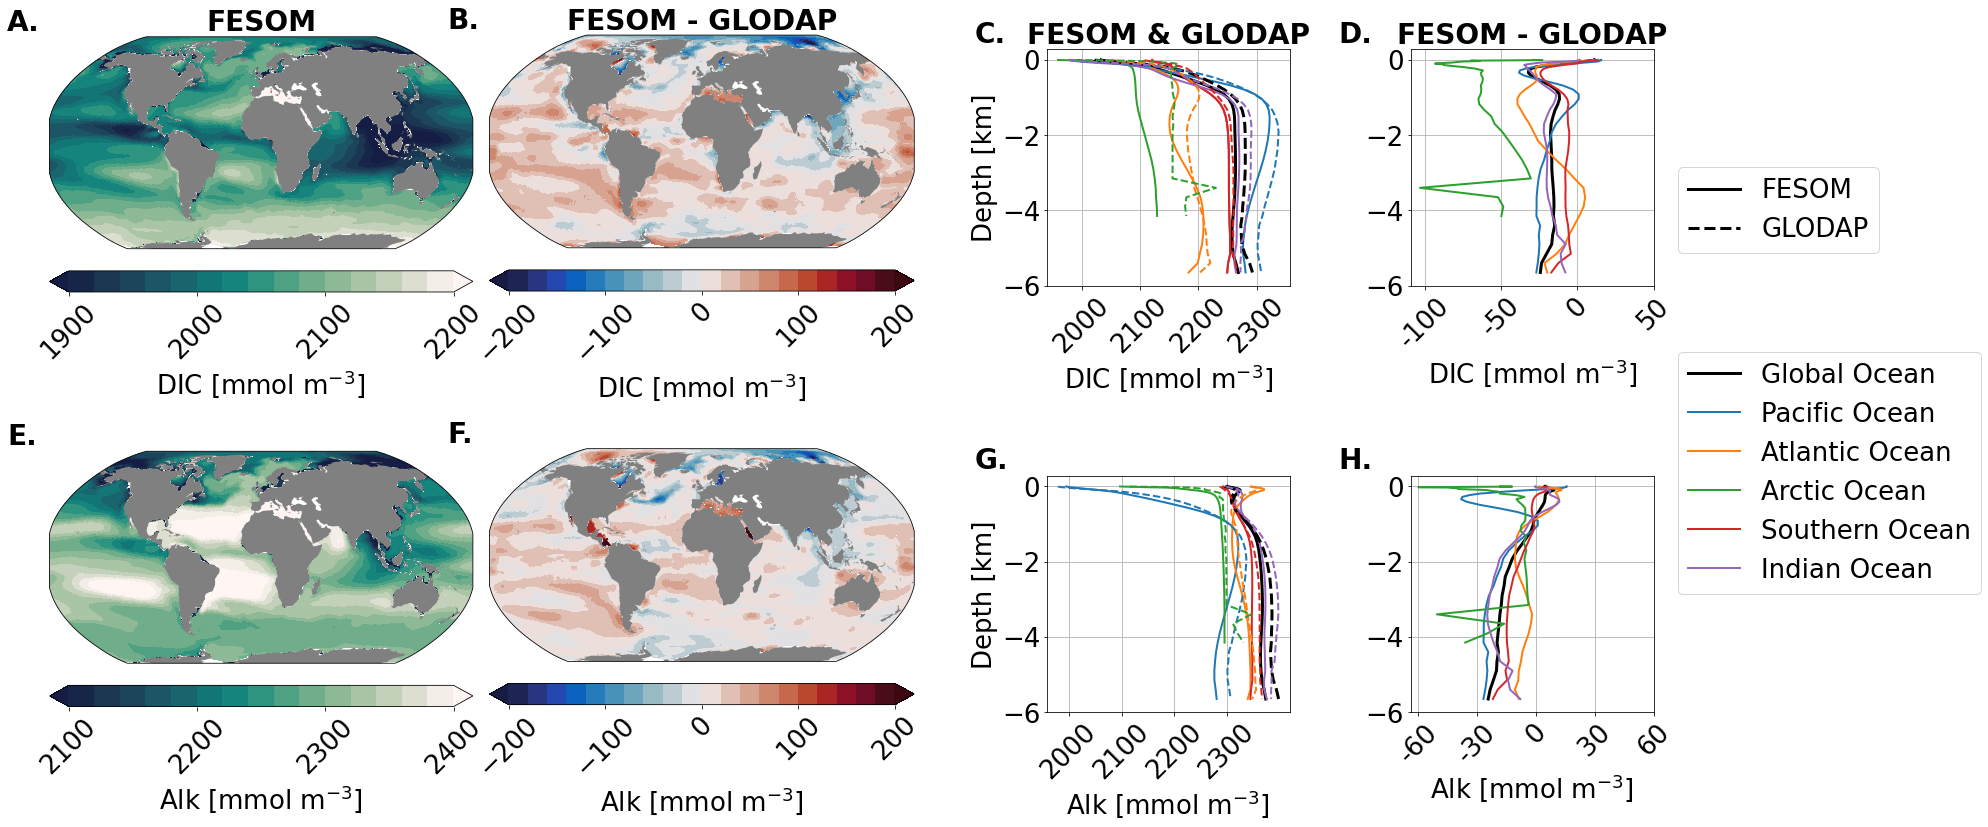

In [7]:
# plotting

fig = plt.figure(figsize=(25, 25), facecolor='w', edgecolor='k', constrained_layout=True) # 20,20

ax1      = fig.add_subplot(441, projection=ccrs.Robinson())
ax1.set_extent(box, crs=ccrs.PlateCarree())
image1 = ax1.contourf(
                lon_cyc_DIC,
                latreg,
                data_int_cyc_DIC,
                levels=data_levels_DIC,
                transform=ccrs.PlateCarree(),
                cmap=cmo.cm.tempo_r,
                extend='both')
ax1.add_feature(cfeature.LAND, zorder=1, edgecolor='none', facecolor='gray')
cbar1 = fig.colorbar(image1, ax=ax1, location = 'bottom',ticks=np.arange(1900,2250,100)*factor, fraction=0.046, pad=0.04)#, size="5%", pad="2%"
cbar1.set_label(unit_dic, fontsize=26)
cbar1.ax.tick_params(labelsize=26,rotation=45)

ax2      = fig.add_subplot(442, projection=ccrs.Robinson())
ax2.set_extent(box, crs=ccrs.PlateCarree())
image2 = ax2.contourf(
                lon_cyc_DIC_anom,
                latreg,
                data_int_cyc_DIC_anom,
                levels=data_levels_DIC_anom,
                transform=ccrs.PlateCarree(),
                cmap=cmo.cm.balance,
                extend='both')
ax2.add_feature(cfeature.LAND, zorder=1, edgecolor='none', facecolor='gray')
cbar2 = fig.colorbar(image2, ax=ax2, location = 'bottom',ticks=np.arange(-200,201,100) * factor, fraction=0.046, pad=0.04)#, size="5%", pad="2%"
cbar2.set_label(unit_dic, fontsize=26)
cbar2.ax.tick_params(labelsize=26,rotation=45)

ax3      = fig.add_subplot(443)
box3 = ax3.get_position()
ax3.set_position([box3.x0+0.05, box3.y0+0.04, box3.width * 0.8 , box3.height * 0.8])
ax3.plot(DICfesom_weighted_Global, mesh.zlev[:-1]/1000,label = 'FESOM', color = 'k', lw=3)
ax3.plot(DICfesom_weighted_Pacific, mesh.zlev[:-1]/1000,label = None, color = 'C0', lw=2)
ax3.plot(DICfesom_weighted_Atlantic, mesh.zlev[:-1]/1000,label = None, color = 'C1', lw=2)
ax3.plot(DICfesom_weighted_Arctic, mesh.zlev[:-1]/1000,label = None, color = 'C2', lw=2)
ax3.plot(DICfesom_weighted_Southern, mesh.zlev[:-1]/1000,label = None, color = 'C3', lw=2)
ax3.plot(DICfesom_weighted_Southern, mesh.zlev[:-1]/1000,label = None, color = 'C3', lw=2)
ax3.plot(DICfesom_weighted_Indian, mesh.zlev[:-1]/1000,label = None, color = 'C4', lw=2)
ax3.plot(DICglo_weighted_Global, mesh.zlev[:-1]/1000,label = 'GLODAP', color = 'k', lw=3, linestyle = '--')
ax3.plot(DICglo_weighted_Pacific, mesh.zlev[:-1]/1000,label = None, color = 'C0', lw=2, linestyle = '--')
ax3.plot(DICglo_weighted_Atlantic, mesh.zlev[:-1]/1000,label = None, color = 'C1', lw=2, linestyle = '--')
ax3.plot(DICglo_weighted_Arctic, mesh.zlev[:-1]/1000,label = None, color = 'C2', lw=2, linestyle = '--')
ax3.plot(DICglo_weighted_Southern, mesh.zlev[:-1]/1000,label = None, color = 'C3', lw=2, linestyle = '--')
ax3.plot(DICglo_weighted_Indian, mesh.zlev[:-1]/1000,label = None, color = 'C4', lw=2, linestyle = '--')
ax3.set_ylabel('Depth [km]', fontsize=26)
ax3.set_xlabel(unit_dic, fontsize=26)
ax3.tick_params(labelsize=26)
ax3.set_yticks([0,-2,-4,-6])
ax3.set_xticks(np.arange(2000,2400,100))
ax3.set_xticklabels([2000,2100,2200,2300],rotation=45)
ax3.legend(bbox_to_anchor=(2.6, 0.5), loc='upper left', borderaxespad=0., fontsize=26)
ax3.grid()

ax4      = fig.add_subplot(444)
box4 = ax4.get_position()
ax4.set_position([box4.x0+0.05, box4.y0+0.04, box4.width * 0.8 , box4.height * 0.8])
ax4.plot(DICfesom_weighted_Global-DICglo_weighted_Global, mesh.zlev[:-1]/1000,label = 'Global Ocean', color = 'k', lw=3)
ax4.plot(DICfesom_weighted_Pacific-DICglo_weighted_Pacific, mesh.zlev[:-1]/1000,label = 'Pacific Ocean', color = 'C0', lw=2)
ax4.plot(DICfesom_weighted_Atlantic-DICglo_weighted_Atlantic, mesh.zlev[:-1]/1000,label = 'Atlantic Ocean', color = 'C1', lw=2)
ax4.plot(DICfesom_weighted_Arctic-DICglo_weighted_Arctic, mesh.zlev[:-1]/1000,label = 'Arctic Ocean', color = 'C2', lw=2)
ax4.plot(DICfesom_weighted_Southern-DICglo_weighted_Southern, mesh.zlev[:-1]/1000,label = 'Southern Ocean', color = 'C3', lw=2)
ax4.plot(DICfesom_weighted_Indian-DICglo_weighted_Indian, mesh.zlev[:-1]/1000,label = 'Indian Ocean', color = 'C4', lw=2)
ax4.set_xlabel(unit_dic, fontsize=26)
ax4.tick_params(labelsize=26)
ax4.set_yticks([0,-2,-4,-6])
ax4.set_xticks(np.arange(-100,100,50))
ax4.set_xticklabels([-100,-50,0,50],rotation=45)
ax4.grid()

ax5      = fig.add_subplot(445, projection=ccrs.Robinson())
ax5.set_extent(box, crs=ccrs.PlateCarree())
image5 = ax5.contourf(
                lon_cyc_Alk,
                latreg,
                data_int_cyc_Alk,
                levels=data_levels_Alk,
                transform=ccrs.PlateCarree(),
                cmap=cmo.cm.tempo_r,
                extend='both')
ax5.add_feature(cfeature.LAND, zorder=1, edgecolor='none', facecolor='gray')
cbar5 = fig.colorbar(image5, ax=ax5, location = 'bottom',ticks=np.arange(2100,2450,100)*factor, fraction=0.046, pad=0.04)#, size="5%", pad="2%"
cbar5.set_label(unit_alk, fontsize=26)
cbar5.ax.tick_params(labelsize=26,rotation=45)

ax6      = fig.add_subplot(446, projection=ccrs.Robinson())
ax6.set_extent(box, crs=ccrs.PlateCarree())
image6 = ax6.contourf(
                lon_cyc_Alk_anom,
                latreg,
                data_int_cyc_Alk_anom,
                levels=data_levels_Alk_anom,
                transform=ccrs.PlateCarree(),
                cmap=cmo.cm.balance,
                extend='both')
ax6.add_feature(cfeature.LAND, zorder=1, edgecolor='none', facecolor='gray')
cbar6 = fig.colorbar(image6, ax=ax6, location = 'bottom',ticks=np.arange(-200,201,100) * factor, fraction=0.046, pad=0.04)#, size="5%", pad="2%"
cbar6.set_label(unit_alk, fontsize=26)
cbar6.ax.tick_params(labelsize=26,rotation=45)

ax7      = fig.add_subplot(447)
box7 = ax7.get_position()
ax7.set_position([box7.x0+0.05, box7.y0, box7.width * 0.8 , box7.height * 0.8])
ax7.plot(Alkfesom_weighted_Global, mesh.zlev[:-1]/1000,label = 'Global Ocean', color = 'k', lw=3)
ax7.plot(Alkfesom_weighted_Pacific, mesh.zlev[:-1]/1000,label = 'Pacific Ocean', color = 'C0', lw=2)
ax7.plot(Alkfesom_weighted_Atlantic, mesh.zlev[:-1]/1000,label = 'Atlantic Ocean', color = 'C1', lw=2)
ax7.plot(Alkfesom_weighted_Arctic, mesh.zlev[:-1]/1000,label = 'Arctic Ocean', color = 'C2', lw=2)
ax7.plot(Alkfesom_weighted_Southern, mesh.zlev[:-1]/1000,label = 'Southern Ocean', color = 'C3', lw=2)
ax7.plot(Alkfesom_weighted_Indian, mesh.zlev[:-1]/1000,label = 'Indian Ocean', color = 'C4', lw=2)
ax7.plot(Alkglo_weighted_Global, mesh.zlev[:-1]/1000,label = 'Global Ocean', color = 'k', lw=3, linestyle = '--')
ax7.plot(Alkglo_weighted_Pacific, mesh.zlev[:-1]/1000,label = 'Pacific Ocean', color = 'C0', lw=2, linestyle = '--')
ax7.plot(Alkglo_weighted_Atlantic, mesh.zlev[:-1]/1000,label = 'Atlantic Ocean', color = 'C1', lw=2, linestyle = '--')
ax7.plot(Alkglo_weighted_Arctic, mesh.zlev[:-1]/1000,label = 'Arctic Ocean', color = 'C2', lw=2, linestyle = '--')
ax7.plot(Alkglo_weighted_Southern, mesh.zlev[:-1]/1000,label = 'Southern Ocean', color = 'C3', lw=2, linestyle = '--')
ax7.plot(Alkglo_weighted_Indian, mesh.zlev[:-1]/1000,label = 'Indian Ocean', color = 'C4', lw=2, linestyle = '--')
ax7.tick_params(labelsize=26)
ax7.set_ylabel('Depth [km]',fontsize=26)
ax7.set_xlabel(unit_alk,fontsize=26)
ax7.set_xticks(np.arange(2000,2400,100))
ax7.set_xticklabels([2000,2100,2200,2300],rotation=45)
ax7.set_yticks([0,-2,-4,-6])
ax7.grid()

ax8      = fig.add_subplot(448)
box8 = ax8.get_position()
ax8.set_position([box8.x0+0.05, box8.y0, box8.width * 0.8 , box8.height * 0.8])
ax8.plot(Alkfesom_weighted_Global-Alkglo_weighted_Global, mesh.zlev[:-1]/1000,label = 'Global Ocean', color = 'k', lw=3)
ax8.plot(Alkfesom_weighted_Pacific-Alkglo_weighted_Pacific, mesh.zlev[:-1]/1000,label = 'Pacific Ocean', color = 'C0', lw=2)
ax8.plot(Alkfesom_weighted_Atlantic-Alkglo_weighted_Atlantic, mesh.zlev[:-1]/1000,label = 'Atlantic Ocean', color = 'C1', lw=2)
ax8.plot(Alkfesom_weighted_Arctic-Alkglo_weighted_Arctic, mesh.zlev[:-1]/1000,label = 'Arctic Ocean', color = 'C2', lw=2)
ax8.plot(Alkfesom_weighted_Southern-Alkglo_weighted_Southern, mesh.zlev[:-1]/1000,label = 'Southern Ocean', color = 'C3', lw=2)
ax8.plot(Alkfesom_weighted_Indian-Alkglo_weighted_Indian, mesh.zlev[:-1]/1000,label = 'Indian Ocean', color = 'C4', lw=2)
ax8.tick_params(labelsize=26)
ax8.set_xlabel(unit_alk,fontsize=26)
ax8.set_yticks([0,-2,-4,-6])
ax8.set_xticks(np.arange(-60,90,30))
ax8.set_xticklabels([-60,-30,0,30,60],rotation=45)
ax8.legend(bbox_to_anchor=(1.1, 0.5), loc='lower left', borderaxespad=0., fontsize=26)
ax8.grid()

ax1.text(-0.1, 1.03, 'A.', transform=ax1.transAxes,
            size=28, weight='bold')
ax2.text(-0.1, 1.03, 'B.', transform=ax2.transAxes,
            size=28, weight='bold')
ax3.text(-0.3, 1.03, 'C.', transform=ax3.transAxes,
            size=28, weight='bold')
ax4.text(-0.3, 1.03, 'D.', transform=ax4.transAxes,
            size=28, weight='bold')
ax5.text(-0.1, 1.03, 'E.', transform=ax5.transAxes,
            size=28, weight='bold')
ax6.text(-0.1, 1.03, 'F.', transform=ax6.transAxes,
            size=28, weight='bold')
ax7.text(-0.3, 1.03, 'G.', transform=ax7.transAxes,
            size=28, weight='bold')
ax8.text(-0.3, 1.03, 'H.', transform=ax8.transAxes,
            size=28, weight='bold')

ax1.set_title('FESOM',size=28, weight='bold')
ax2.set_title('FESOM - GLODAP',size=28, weight='bold')
ax3.set_title('FESOM & GLODAP',size=28, weight='bold')
ax4.set_title('FESOM - GLODAP',size=28, weight='bold')

#fig.subplots_adjust(wspace=0.02,hspace=0.12)
plt.savefig('FIG5.png', dpi = 300, bbox_inches='tight') 